In [1]:
import sys, os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5]

spark = (
    SparkSession.builder.appName("PySpark Hive Session from Jupyter Notebook")
    .config(
        "spark.master",
        "spark://{}:{}".format("spark-master", "7077"),
    )
    .config(
        "spark.hadoop.hive.metastore.uris",
        "thrift://{}:{}".format("hive-metastore", "9083"),
    )
    .config("spark.sql.warehouse.dir", "/hive/warehouse/dir")
    .config("spark.executor.memory", "10g")
    .config("spark.executor.cores", "2")
    .config("spark.executor.instances", "1")
    .config("spark.debug.maxToStringFields", "100")
    .enableHiveSupport()
    .getOrCreate()
)

23/10/22 12:37:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
"""market_trade columns
    id string COMMENT 'id of the crypto currency',
    trade_id bigint COMMENT 'trade id',
    takerSide string COMMENT 'trade side (buy, sell)',
    amount float COMMENT 'quote units traded',
    quantity float COMMENT 'base units traded',
    price float COMMENT 'trade price',
    createTime bigint COMMENT 'time the trade was created',
    ts_send bigint COMMENT 'time the record was pushed',
    dt_create_utc date COMMENT 'date when the record was created in a trading system',
    ts_create_utc timestamp COMMENT 'timestamp when the record was created in a trading system',
    ts_insert_utc timestamp COMMENT 'timestamp when data was inserted to cassandra table',
    year smallint COMMENT 'year at the order data was created', 
    month smallint COMMENT 'month at the order data was created', 
    day smallint COMMENT 'day at the order data was created', 
    hour smallint COMMENT 'hour at the order data was created'
    minute smallint COMMENT 'minute at the order data was created',
    second smallint COMMENT 'second at the order data was created'
"""
market_trade_raw_df = spark.sql(
    """
        select 
            * 
        from 
            crypto_raw.market_trade 
        where 
            id = "BTC_USDT"
    """
)


Column description details
- trade_id
    - One trade_id has one record
    - One trade can be classified into "buy" and "sell", which exist in the takerSide column.
- amount & quantity
    - How much money was traded / How many coins were traded.
    - e.g., BTC/USDT, the quote unit is USDT, the base unit is BTC.
    - When 1 BTC = 10,000 USDT, amount = 5,000 in a record means 0.5 BTC (= quantity) was traded.
    - Sumurating amount is equal to the volume in the period.
- price
    - The traded was done by this price.
    - If price = 10,000$, someone sold/bought BTC coins in the price.

In [3]:
# How many trades were completed in a minute and in a second.
# taker side: buy
filter_takerside_buy = market_trade_raw_df["takerSide"] == "buy"
buy_order_count_by_minute = market_trade_raw_df.where(filter_takerside_buy) \
    .select(date_trunc("minute",'ts_create_utc').alias("ts_trade"),'trade_id','price') \
    .groupBy(['ts_trade']) \
    .agg(count("trade_id").alias("num_buy_trade_in_minute"), \
         avg("price").alias("avg_buy_trade_price") ) \
    .select("ts_trade","num_buy_trade_in_minute","avg_buy_trade_price") \
    .orderBy(['ts_trade'])

buy_order_count_by_second = market_trade_raw_df.where(filter_takerside_buy) \
    .select(date_trunc("second",'ts_create_utc').alias("ts_trade"),'trade_id','price') \
    .groupBy(['ts_trade']) \
    .agg(count("trade_id").alias("num_buy_trade_in_second"), \
         avg("price").alias("avg_buy_trade_price") ) \
    .select("ts_trade","num_buy_trade_in_second","avg_buy_trade_price") \
    .orderBy(['ts_trade'])


# taker side: sell
filter_takerside_sell = market_trade_raw_df["takerSide"] == "sell"
sell_order_count_by_minute = market_trade_raw_df.where(filter_takerside_sell) \
    .select(date_trunc("minute",'ts_create_utc').alias("ts_trade"),'trade_id','price') \
    .groupBy(['ts_trade']) \
    .agg(count("trade_id").alias("num_sell_trade_in_minute"), \
         avg("price").alias("avg_sell_trade_price") ) \
    .select("ts_trade","num_sell_trade_in_minute","avg_sell_trade_price") \
    .orderBy(['ts_trade'])


sell_order_count_by_second = market_trade_raw_df.where(filter_takerside_sell) \
    .select(date_trunc("second",'ts_create_utc').alias("ts_trade"),'trade_id','price') \
    .groupBy(['ts_trade']) \
    .agg(count("trade_id").alias("num_sell_trade_in_second"), \
         avg("price").alias("avg_sell_trade_price") ) \
    .select("ts_trade","num_sell_trade_in_second","avg_sell_trade_price") \
    .orderBy(['ts_trade'])

23/10/22 12:37:27 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


<IPython.core.display.Javascript object>


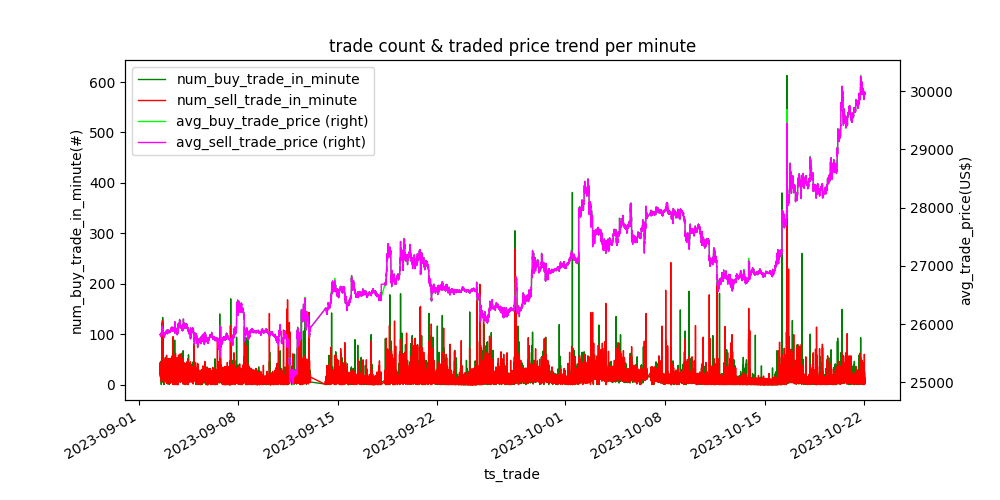

Text(0, 0.5, 'avg_trade_price(US$)')

In [4]:
order_count_by_minute = buy_order_count_by_minute. \
    join(sell_order_count_by_minute, on='ts_trade', how='fullouter') \
    .orderBy(['ts_trade']) \
    .toPandas()

# fill Nan
order_count_by_minute['num_buy_trade_in_minute'] = order_count_by_minute['num_buy_trade_in_minute'].fillna(0)
order_count_by_minute['num_sell_trade_in_minute'] = order_count_by_minute['num_sell_trade_in_minute'].fillna(0)
order_count_by_minute['avg_buy_trade_price'] = order_count_by_minute['avg_buy_trade_price'].fillna(method='bfill')
order_count_by_minute['avg_sell_trade_price'] = order_count_by_minute['avg_sell_trade_price'].fillna(method='bfill')


# creating axes object and defining plot
ax = order_count_by_minute[["ts_trade","num_buy_trade_in_minute"]] \
    .plot(kind = 'line', x = 'ts_trade', \
         y = 'num_buy_trade_in_minute', \
         color = 'Green', linewidth = 1)

ax2 = order_count_by_minute[["ts_trade","num_sell_trade_in_minute"]] \
    .plot(kind = 'line', x = 'ts_trade', \
         y = 'num_sell_trade_in_minute', \
         color = 'Red', linewidth = 1, ax = ax)
 
ax3 = order_count_by_minute[["ts_trade","avg_buy_trade_price"]] \
    .plot(kind = 'line', x = 'ts_trade', \
          y = 'avg_buy_trade_price', secondary_y = True, \
          color = 'lime',  linewidth = 1, ax = ax)
    
ax4 = order_count_by_minute[["ts_trade","avg_sell_trade_price"]] \
    .plot(kind = 'line', x = 'ts_trade', \
          y = 'avg_sell_trade_price', secondary_y = True, \
          color = 'magenta',  linewidth = 1, ax = ax)
 
#title of the plot
plt.title("trade count & traded price trend per minute")
 
#labeling x and y-axis
ax.set_xlabel('ts_trade', color = 'black')
ax.set_ylabel('num_buy_trade_in_minute(#)', color = "black")
ax3.set_ylabel('avg_trade_price(US$)', color = 'black')

<IPython.core.display.Javascript object>


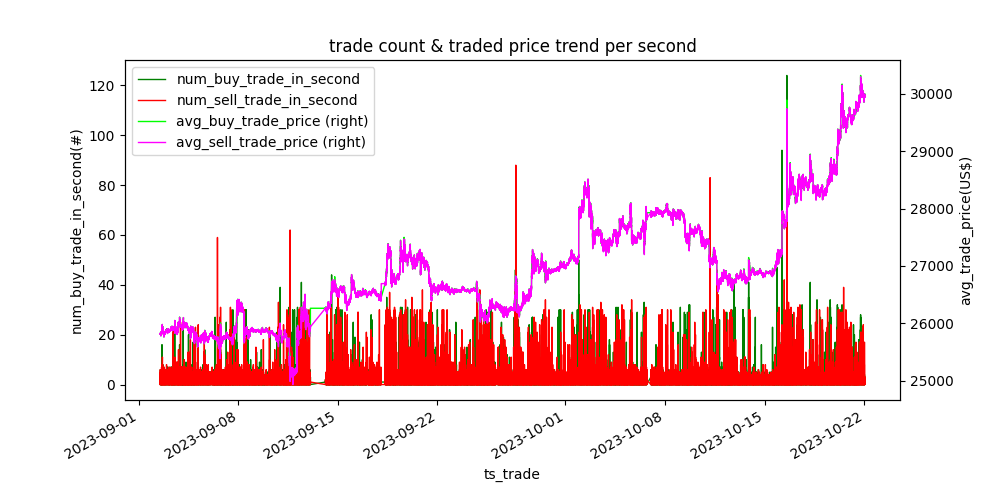

Text(0, 0.5, 'avg_trade_price(US$)')

In [5]:
order_count_by_second = buy_order_count_by_second. \
    join(sell_order_count_by_second, on='ts_trade', how='fullouter') \
    .orderBy(['ts_trade']) \
    .toPandas()

order_count_by_second['num_buy_trade_in_second'] = order_count_by_second['num_buy_trade_in_second'].fillna(0)
order_count_by_second['num_sell_trade_in_second'] = order_count_by_second['num_sell_trade_in_second'].fillna(0)
order_count_by_second['avg_buy_trade_price'] = order_count_by_second['avg_buy_trade_price'].fillna(method='bfill')
order_count_by_second['avg_sell_trade_price'] = order_count_by_second['avg_sell_trade_price'].fillna(method='bfill')

# creating axes object and defining plot
ax = order_count_by_second[["ts_trade","num_buy_trade_in_second"]] \
    .plot(kind = 'line', x = 'ts_trade', \
         y = 'num_buy_trade_in_second', \
         color = 'Green', linewidth = 1)

ax2 = order_count_by_second[["ts_trade","num_sell_trade_in_second"]] \
    .plot(kind = 'line', x = 'ts_trade', \
         y = 'num_sell_trade_in_second', \
         color = 'Red', linewidth = 1, ax = ax)
 
ax3 = order_count_by_second[["ts_trade","avg_buy_trade_price"]] \
    .plot(kind = 'line', x = 'ts_trade', \
          y = 'avg_buy_trade_price', secondary_y = True, \
          color = 'lime',  linewidth = 1, ax = ax)
    
ax4 = order_count_by_second[["ts_trade","avg_sell_trade_price"]] \
    .plot(kind = 'line', x = 'ts_trade', \
          y = 'avg_sell_trade_price', secondary_y = True, \
          color = 'magenta',  linewidth = 1, ax = ax)
 
#title of the plot
plt.title("trade count & traded price trend per second")
 
#labeling x and y-axis
ax.set_xlabel('ts_trade', color = 'black')
ax.set_ylabel('num_buy_trade_in_second(#)', color = "black")
ax3.set_ylabel('avg_trade_price(US$)', color = 'black')